# Inference the results of the thrmodynamic experiment

In [1]:
import sys
import gc
sys.path.append('../')

In [2]:
from model.data_loader import fetch_dataloader,fetch_inference_loader
from model.data_loader import params as data_params
from model.model_cfg import CFG
# from model.net import ProteinEnergyNet
from model.hydro_net import PEM
from train_utils import *
import torch
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import gc
import time
import sys
import glob
import pandas as pd
import wandb
import constants as C

In [3]:
os.chdir("../")
os.getcwd()

'/cs/casp15/Shahar/DeepPEF'

# Inference some examples

In [4]:
model = PEM(layers=CFG.num_layers,gaussian_coef=CFG.gaussian_coef).to(CFG.device)
model.name = "PEM-thermodynamic cycle"
# optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
optimizer = optim.SGD(model.parameters(), lr=CFG.lr)
# Get total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 393517


In [5]:
CFG.model_path

'./res/trianed_models-newDecoys/'

In [6]:
model_path = "./res/trianed_models-no_exdu_nosigmoid//best_model.pt"
model,optimizer,epoch,loss,valid_loss = load_checkpoint(model_path,model,optimizer,device=CFG.device)

Loaded model from ./res/trianed_models-no_exdu_nosigmoid//best_model.pt


1A0N example

In [53]:
def add_cb(crd_coords):
        """
        Add the Cbeta atom to the coordinates
        Args:
            crd_coords (tensor): tensor of shape [n_residues,3,3]

        Returns:
            crd_coords: tensor shape [n_residues,4,3]
        """
        # Get the coordinates of the backbone atoms
        N, CA, C = crd_coords[:, 0], crd_coords[:, 1], crd_coords[:, 2]
        # CB = CA + c1*(N-CA) + c2*(C-CA) + c3* (N-CA)x(C-CA)
        CAmN = N - CA
        # CAmN = CAmN / torch.sqrt(CAmN ** 2).sum(dim=2, keepdim=True)
        CAmC = C - CA
        # CAmC = CAmC / torch.sqrt(CAmC ** 2).sum(dim=2, keepdim=True)
        ANxAC = torch.cross(CAmN, CAmC, dim=1)

        A = torch.cat((CAmN.reshape(-1, 1), CAmC.reshape(-1, 1), ANxAC.reshape(-1, 1)), dim=1)
        c = torch.tensor([0.5507, 0.5354, -0.5691]) / 100  # torch.tensor([1.1930, 1.2106, -2.7906]) #
        b = (A @ c).reshape(-1,3)
        CB = CA - b
      
        # Add Cbeta coordinates to existing coordinates array
        crd_coords = torch.cat((crd_coords, CB.unsqueeze(1)), dim=1)
        return crd_coords
    

In [71]:

data_dir = glob.glob('./data/casp12_data_30/train/*')
item_path = './data/casp12_data_100/train/1A0N_2_B'
# item_path = './data/casp12_data_100/train/1WR4_1_A'
# item_path = './data/casp12_data_100/train/2B89_1_A'
decoy_path = data_dir[np.random.randint(len(data_dir))]
while decoy_path == item_path:
    decoy_path = data_dir[np.random.randint(len(data_dir))]
# load data
id = torch.load(item_path + '/id.pt')
crd_backbone = torch.tensor(torch.load(item_path + '/crd_backbone.pt'),dtype=torch.get_default_dtype()) #backbone coordinates N,Calpha,C
crd_decoy = torch.tensor(torch.load(decoy_path + '/crd_backbone.pt'),dtype=torch.get_default_dtype()) #backbone coordinates N,Calpha,C

mask = torch.load(item_path + '/mask.pt')
mask_decoy = torch.load(decoy_path + '/mask.pt')
# change to 1,0 mask
mask = torch.tensor(np.where(np.array(list(mask))=='+',1,0))
mask_decoy = torch.tensor(np.where(np.array(list(mask_decoy))=='+',1,0))
# one hot encoding of the sequence
seq_one_hot = torch.load(item_path + '/seq_one_hot.pt')
seq = torch.load(item_path + '/seq.pt')
seq_decoy = torch.load(decoy_path + '/seq.pt')
proT5_emb = torch.load(item_path + '/proT5_emb.pt')
# proT5_emb = torch.zeros((len(seq),1024)) # for testing
ang = torch.tensor(torch.load(item_path + '/ang.pt'))
ang_backbone = torch.clone(ang)[:,:3] #angles for the backbone phi, psi, omega
# Add Cbeta atom to the coordinates
crd_backbone = add_cb(crd_backbone)
crd_decoy = add_cb(crd_decoy)
# Convert to angstrom
crd_backbone = crd_backbone * C.NANO_TO_ANGSTROM 
crd_decoy = crd_decoy * C.NANO_TO_ANGSTROM 

# ProT5 embedding for protein mutation
proT5_mut = torch.load(item_path + '/proT5_emb_mut.pt')
seq_mut =  torch.load(item_path + '/seq_mut.pt')
# proT5_mut = torch.zeros((len(seq),1024)) # for testing
# seq_mut = seq # for testing
# unsqueeze the data and save it in a list
data = id, crd_backbone.unsqueeze(0), mask.unsqueeze(0), seq_one_hot.unsqueeze(0), seq,ang_backbone.unsqueeze(0),ang.unsqueeze(0), proT5_emb.unsqueeze(0), proT5_mut.unsqueeze(0),[seq_mut],\
    crd_decoy.unsqueeze(0), mask_decoy.unsqueeze(0), [seq_decoy]

In [72]:
s1 = seq
s2 = seq_mut
# get diffrent characters
diff = []
for i in range(len(s1)):
    if s1[i] != s2[i]:
        diff.append(i)
print(diff)
print(s1[diff[0]],s2[diff[0]])

[41, 66]
E A


In [73]:
mask

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [74]:
def print_shapes(data):
    id, crd_backbone, mask, seq_one_hot, seq,ang_backbone, ang,\
                proT5_emb, proT5_mut,seq_mut, crd_decoy, mask_crd_decoy, seq_crd_decoy = data
    print(f"id: {id}")
    print(f"crd_backbone: {crd_backbone.shape}")
    print(f"mask: {mask.shape}")
    print(f"seq_one_hot: {seq_one_hot.shape}")
    print(f"seq: {seq}")
    print(f"ang_backbone: {ang_backbone.shape}")
    print(f"ang: {ang.shape}")
    print(f"proT5_emb: {proT5_emb.shape}")
    print(f"proT5_mut: {proT5_mut.shape}")
    print(f"seq_mut: {len(seq_mut)}")
    print(f"crd_decoy: {crd_decoy.shape}")
    print(f"mask_crd_decoy: {mask_crd_decoy.shape}")
    print(f"seq_crd_decoy: {len(seq_crd_decoy)}")
    return
print_shapes(data)

id: 1A0N_2_B
crd_backbone: torch.Size([1, 69, 4, 3])
mask: torch.Size([1, 69])
seq_one_hot: torch.Size([1, 69, 20])
seq: GSTGVTLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPVDSIQAEE
ang_backbone: torch.Size([1, 69, 3])
ang: torch.Size([1, 69, 12])
proT5_emb: torch.Size([1, 69, 1024])
proT5_mut: torch.Size([1, 69, 1024])
seq_mut: 1
crd_decoy: torch.Size([1, 135, 4, 3])
mask_crd_decoy: torch.Size([1, 135])
seq_crd_decoy: 1


In [58]:
# Add zero padding to the sequence
def pad_data(data,max_len=500):
    id, crd_backbone, mask, seq_one_hot, seq,ang_backbone, ang,\
                proT5_emb, proT5_mut,seq_mut, crd_decoy, mask_crd_decoy, seq_crd_decoy = data
    pad_len = max_len - crd_backbone.shape[1]
    crd_backbone = F.pad(crd_backbone,(0,0,0,0,0,pad_len))
    seq_one_hot = F.pad(seq_one_hot,(0,0,0,pad_len))
    proT5_emb = F.pad(proT5_emb,(0,0,0,pad_len))
    proT5_mut = F.pad(proT5_mut,(0,0,0,pad_len))
    mask = F.pad(mask,(0,pad_len))
    ang = F.pad(ang,(0,0,0,pad_len))
    ang_backbone = F.pad(ang_backbone,(0,0,0,pad_len))
    return (id, crd_backbone, mask, seq_one_hot, seq,ang_backbone, ang,\
                proT5_emb, proT5_mut,seq_mut, crd_decoy, mask_crd_decoy, seq_crd_decoy)
                
data = pad_data(data)
print_shapes(data)

id: 1A0N_2_B
crd_backbone: torch.Size([1, 500, 4, 3])
mask: torch.Size([1, 500])
seq_one_hot: torch.Size([1, 500, 20])
seq: GSTGVTLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPVDSIQAEE
ang_backbone: torch.Size([1, 500, 3])
ang: torch.Size([1, 500, 12])
proT5_emb: torch.Size([1, 500, 1024])
proT5_mut: torch.Size([1, 500, 1024])
seq_mut: 1
crd_decoy: torch.Size([1, 41, 4, 3])
mask_crd_decoy: torch.Size([1, 41])
seq_crd_decoy: 1


In [59]:
# evaluate model 
model.eval()
# model.train()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [75]:
id, crd_backbone, mask, seq_one_hot, seq,ang_backbone, ang,\
                proT5_emb, proT5_mut,seq_mut, crd_decoy, mask_crd_decoy, seq_crd_decoy = data
            
# wild type and mutant type
Xjf = crd_backbone.to(device) # wilde type structure folded
Xju = torch.clone(Xjf).to(device) # wilde type structure unfolded
Xcd = crd_decoy.to(device) # decoy structure

# change the decoy len to match the native len
if Xcd.shape[1] > Xjf.shape[1]:
    Xcd = Xcd[:,:Xjf.shape[1],:,:]
    mask_crd_decoy = mask_crd_decoy[:,:Xjf.shape[1]]
elif Xcd.shape[1] < Xjf.shape[1]:
    # add zeros to the end of the decoy
    Xcd = torch.cat((Xcd, torch.zeros(Xjf.shape[0],Xjf.shape[1] - Xcd.shape[1], *Xcd.shape[2:]).to(device)), dim=1)
    mask_crd_decoy = torch.cat((mask_crd_decoy, torch.zeros(mask_crd_decoy.shape[0],mask.shape[1] - mask_crd_decoy.shape[1])), dim=1)
    
# native structure and decoy structure
Xd = torch.clone(Xjf).to(device)
Xdu = torch.clone(Xjf).to(device)
seq_one_hot = seq_one_hot.to(device) # [batch_size,20,seq_len]

# create decoy sequence
seq_decoy,mask_decoy, proT5_emb_decoy = mix_A_acid(seq_one_hot = seq_one_hot, emb=proT5_emb, mask = mask,val_type='train',device=device)

#emb = torch.cat((esm_embed,seq),dim=2)
emb = seq_one_hot.to(device)
emb_decoy = seq_decoy.to(device)

# move proT5_emb to device
proT5_emb_decoy, proT5_emb = proT5_emb_decoy.to(device), proT5_emb.to(device)

# zero the parameter gradients
optimizer.zero_grad()
# squeeze the data
Xd, Xjf, Xju, Xcd, Xdu = Xd.squeeze(), Xjf.squeeze(), Xju.squeeze(), Xcd.squeeze(), Xdu.squeeze()
emb_decoy, emb = emb_decoy.squeeze(), emb.squeeze()
mask_decoy, mask, mask_crd_decoy= mask_decoy.squeeze(), mask.squeeze(), mask_crd_decoy.squeeze()
proT5_emb_decoy, proT5_emb = proT5_emb_decoy.squeeze(), proT5_emb.squeeze()

# get folded graph  
Xjf = get_graph(Xjf, emb, proT5_emb, mask)
# get unfolded graph
Xju = get_unfolded_graph(Xju, emb, proT5_emb, mask)
# get decoy graph
Xd, Xcd, Xdu = get_graph(Xd, emb_decoy, proT5_emb_decoy, mask_decoy), get_graph(Xcd, emb, proT5_emb, mask_crd_decoy), get_unfolded_graph(Xd, emb_decoy, proT5_emb_decoy, mask_decoy)
# create a batch of Xjf,Xkf,Xju,Xku,x_decoy
Xjf,Xju,Xd,Xcd,Xdu= Xjf.unsqueeze(0),Xju.unsqueeze(0),Xd.unsqueeze(0), Xcd.unsqueeze(0), Xdu.unsqueeze(0)  
X = torch.cat((Xjf,Xju,Xd,Xcd,Xdu),dim=0)

with torch.no_grad():
    # half precision validation
    with torch.amp.autocast(device_type="cuda", dtype=CFG.precision):
        # calculate the energy for the folded unfolded and decoy structure
        E = model(X)
        Ejf, Eju, Exd, Ecd, Exdu = E[0], E[1], E[2], E[3], E[4]

In [76]:
print(Ejf.item(), Eju.item(), Exd.item(), Ecd.item())

-72.092529296875 3.5161330699920654 32.22923278808594 16.937253952026367


In [15]:
# calculate the energy difference
dE_wildtype = Eju - Ejf
dE_mutant = Eku - Ekf
dE_decoy = Exd - Ejf
dE_coordsDecoy = Ecd - Ejf
# print as a table
print("Energy difference ")
print(f"Wild type: {dE_wildtype.item()}")
print(f"Mutant: {dE_mutant.item()}")
print(f"Decoy: {dE_decoy.item()}")
print(f"Decoy coordinates: {dE_coordsDecoy.item()}")

Energy difference 
Wild type: 5.723419666290283
Mutant: 5.601985931396484
Decoy: 21.944183349609375
Decoy coordinates: 15.587738037109375


In [18]:
E = model(X,f_type = 'A_inference')
# E = E.squeeze()
Ejf, Ekf, Eju, Eku, Exd = E[0], E[1], E[2], E[3], E[4]

In [19]:
sum_Ejf, sum_Ekf, sum_Eju, sum_Eku, sum_Exd = (Ejf).sum(), (Ekf).sum(), (Eju).sum(), (Eku).sum(), (Exd).sum()
print(sum_Ejf.item(), sum_Ekf.item(), sum_Eju.item(), sum_Eku.item(), sum_Exd.item())
# delta E
dE_wildtype = sum_Eju - sum_Ejf
dE_mutant = sum_Eku - sum_Ekf
dE_decoy = sum_Exd - sum_Ejf
# print as a table
print("Energy difference ")
print(f"Wild type: {dE_wildtype.item()}")
print(f"Mutant: {dE_mutant.item()}")
print(f"Decoy: {dE_decoy.item()}")

4.43651008605957 4.436499118804932 12.033395767211914 12.258563995361328 26.85599136352539
Energy difference 
Wild type: 7.596885681152344
Mutant: 7.8220648765563965
Decoy: 22.41948127746582


(69, 5)


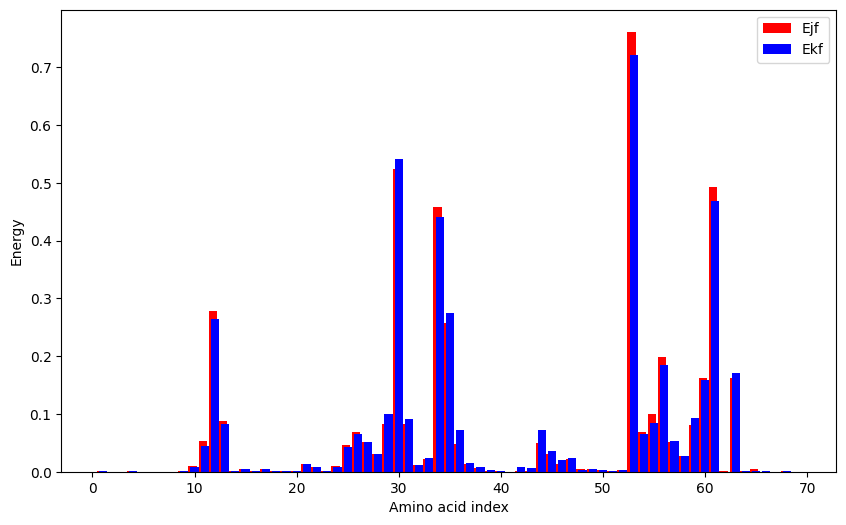

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])


In [20]:
# Categories (x-axis labels)
nodes = Ejf.shape[0]
categories = np.arange(1, nodes+1)  # Assuming 69 data points

# Combine the data into a single array
data = np.hstack((Ejf.detach().cpu().numpy(), Ekf.detach().cpu().numpy(), Eju.detach().cpu().numpy(), Eku.detach().cpu().numpy(), Exd.detach().cpu().numpy()))
print(data.shape)

# Create the figure
fig = plt.figure(figsize=(10, 6))
# Plot bars for each example with separation
bar_width = 0.2
plt.bar(categories-bar_width, data[:, 0], color='red', label='Ejf')
plt.bar(categories, data[:, 1], color='blue', label='Ekf')
# plt.bar(categories+bar_width, data[:, 2], color='green', label='Eju')
# plt.bar(categories, data[:, 3], color='orange', label='Eku')
# plt.bar(categories, data[:, 4], color='purple', label='Exd')


    

# Set labels, title, and legend
plt.xlabel('Amino acid index')
plt.ylabel('Energy')
# plt.set_title('Amino acid energy contribution')
# Specify legend location
plt.legend(loc='upper right')
# Display the plot
# plt.tight_layout()
plt.show()
print(mask)

In [21]:
a = Eku**2-Ekf**2
a[a<0]

tensor([-1.8296e-10, -7.8275e-15, -2.7039e-13, -4.4312e-08, -3.0443e-07,
        -2.2754e-06, -1.7592e-06, -2.6576e-03, -4.0284e-03, -6.1769e-05,
        -1.9732e-07, -9.6246e-08, -1.1597e-07], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [22]:
d_params = data_params(num_workers =CFG.num_workers, batch_size=CFG.batch_size,cuda=CFG.cuda,constraint=CFG.constraint, debug=CFG.debug,dataset='scn')
train_loader, valid_loader,test_loader = fetch_dataloader(data_dir=CFG.data_path, params=d_params)

In [31]:
# define validation function
def validation(model, dataloader, device,epoch,N,optimizer,val_type = 'robust'):
    """
    Validation function for the model.
    """
    valid_loss = 0
    valid_lossd = 0
    valid_lossg = 0
    valid_lossc = 0
    Exd_list = []
    Exn_list = []
    seq_len = []
    lossg_list = []
    lossd_list = []
    ids_list = []
    n_skips = 0
    model.eval() # cant use eval because of the loss function calculation
    count_equal = 0
    with tqdm(dataloader, unit="batch") as tepoch:
       # set progress bar description
        tepoch.set_description(f"Validation: Epoch {epoch}")
        for index, data in (enumerate(tepoch)):
            # Clean the GPU cache
            if(device.type == "cuda" or device.type == "mps"):    
                torch.cuda.empty_cache()
            gc.collect()
            # zero the parameter gradients
            optimizer.zero_grad()
            id, crd_backbone, mask, seq_one_hot, seq,ang_backbone, ang,\
                proT5_emb, proT5_mut,seq_mut, crd_decoy, mask_crd_decoy, seq_crd_decoy = data
            
            # wild type and mutant type
            Xjf = crd_backbone.to(device) # wilde type structure folded
            Xkf = torch.clone(Xjf).to(device) # mutant structure folded
            Xju = torch.clone(Xjf).to(device) # wilde type structure unfolded
            Xku = torch.clone(Xjf).to(device) # mutant structure unfolded
            Xcd = crd_decoy.to(device) # decoy structure

            # change the decoy len to match the native len
            if Xcd.shape[1] > Xjf.shape[1]:
                Xcd = Xcd[:,:Xjf.shape[1],:,:]
                mask_crd_decoy = mask_crd_decoy[:,:Xjf.shape[1]]
            elif Xcd.shape[1] < Xjf.shape[1]:
                # add zeros to the end of the decoy
                Xcd = torch.cat((Xcd, torch.zeros(Xjf.shape[0],Xjf.shape[1] - Xcd.shape[1], *Xcd.shape[2:]).to(device)), dim=1)
                mask_crd_decoy = torch.cat((mask_crd_decoy, torch.zeros(mask_crd_decoy.shape[0],mask.shape[1] - mask_crd_decoy.shape[1])), dim=1)
              
            # native structure and decoy structure
            Xd = torch.clone(Xjf).to(device)
            Xdu = torch.clone(Xjf).to(device)
            seq_one_hot = seq_one_hot.to(device) # [batch_size,20,seq_len]
            
            # create decoy sequence
            seq_decoy,mask_decoy, proT5_emb_decoy = mix_A_acid(seq_one_hot = seq_one_hot, emb=proT5_emb, mask = mask,val_type='train',device=device)
            
            if seq_decoy.shape[1] >CFG.seq_len : # if the sequence is too long, skip it(GPU limitation)
                n_skips += 1
                continue
            #emb = torch.cat((esm_embed,seq),dim=2)
            emb = seq_one_hot.to(device)
            emb_decoy = seq_decoy.to(device)
            emb_mut = get_one_hot(seq_mut[0]).to(device)
            
            # move proT5_emb to device
            proT5_mut, proT5_emb_decoy, proT5_emb = proT5_mut.to(device), proT5_emb_decoy.to(device), proT5_emb.to(device)
           
            # zero the parameter gradients
            optimizer.zero_grad()
            # squeeze the data
            Xd, Xjf, Xkf, Xju, Xku, Xcd, Xdu = Xd.squeeze(), Xjf.squeeze(), Xkf.squeeze(), Xju.squeeze(), Xku.squeeze(), Xcd.squeeze(), Xdu.squeeze()
            emb_decoy, emb, emb_mut = emb_decoy.squeeze(), emb.squeeze(), emb_mut.squeeze()
            mask_decoy, mask, mask_crd_decoy= mask_decoy.squeeze(), mask.squeeze(), mask_crd_decoy.squeeze()
            proT5_emb_decoy, proT5_emb, proT5_mut = proT5_emb_decoy.squeeze(), proT5_emb.squeeze(), proT5_mut.squeeze()
            
            # get folded graph  
            Xjf,Xkf = get_graph(Xjf, emb, proT5_emb, mask), get_graph(Xkf, emb_mut, proT5_mut, mask)
            # get unfolded graph
            Xju,Xku = get_unfolded_graph(Xju, emb, proT5_emb, mask), get_unfolded_graph(Xku, emb_mut, proT5_mut, mask)
            # get decoy graph
            Xd, Xcd, Xdu = get_graph(Xd, emb_decoy, proT5_emb_decoy, mask_decoy), get_graph(Xcd, emb, proT5_emb, mask_crd_decoy), get_unfolded_graph(Xd, emb_decoy, proT5_emb_decoy, mask_decoy)
            # create a batch of Xjf,Xkf,Xju,Xku,x_decoy
            Xjf,Xkf,Xju,Xku,Xd,Xcd,Xdu= Xjf.unsqueeze(0),Xkf.unsqueeze(0),Xju.unsqueeze(0),Xku.unsqueeze(0),Xd.unsqueeze(0), Xcd.unsqueeze(0), Xdu.unsqueeze(0)  
            X = torch.cat((Xjf,Xkf,Xju,Xku,Xd,Xcd,Xdu),dim=0)
            
             # half precision validation
            with torch.amp.autocast(device_type="cuda", dtype=CFG.precision):
                # calculate the energy for the folded unfolded and decoy structure
                E = model(X)
                Ejf, Ekf, Eju, Eku, Exd, Ecd, Exdu = E[0], E[1], E[2], E[3], E[4], E[5], E[6]
                # calculate the loss   
                loss ,lossd, lossg,lossc = criterion(Ejf, Ekf, Eju, Eku, Exd, Xjf, Ecd, Exdu, with_grad = False)
                
            # Add gradient penalty
            Ejf_grad = torch.tensor(0.0).to(device)
            if CFG.gradient_penalty:
                # zero the parameter gradients
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                gc.collect( )
                # half precision training
                with torch.amp.autocast(device_type="cuda", dtype=CFG.precision):
                    # calculate the energy for the wild type
                    Xjf.requires_grad = True
                    Ejf_grad = model(Xjf)[0]
                    lossg = gradient_penalty(Xjf, Ejf_grad)
                    
                loss += lossg # add the gradient penalty to the loss
            
            valid_loss += loss.item() 
            valid_lossd += lossd.item()
            valid_lossg += lossg.item()
            valid_lossc += lossc.item()
            # delete all the variables
            del Xjf,Xkf,Xju,Xku,Xd,emb_decoy, emb, emb_mut, mask_decoy, mask, proT5_emb_decoy, proT5_emb, proT5_mut, X, E, Ejf, Ekf, Eju, Eku, Exd
            torch.cuda.empty_cache()
            gc.collect()
            # update the progress bar
            if index % 1000 == 999:
                print(f"Validation loss: {round(valid_loss/(index + 1),2)}, index: {index}, n_skips: {n_skips}")
    return valid_loss/len(dataloader),valid_lossd/len(dataloader),valid_lossg/len(dataloader),valid_lossc/len(dataloader)

def gradient_penalty(X_native, E_native):
    """Implementing the lossg equation:
        The gradient of a wild type structure should be close to zero.
        Therefore we will add it to the loss as lossg"""
    partial_dx_native = torch.autograd.grad(outputs=E_native, inputs=X_native, grad_outputs=torch.ones_like(E_native),retain_graph = True ,create_graph=True)[0]
    part_dx_native_norm = 0.5*torch.norm(partial_dx_native,p=2)**2
    lossg = torch.log(part_dx_native_norm+1)
    return lossg

def criterion(Ejf, Ekf, Eju, Eku, Exd, X_native, Ecd, Exdu, with_grad = True ):
    """
    The loss function for the model corresponds to 3 main losses:
    1. lossg: the partial derivative of the energy with respect to the native structure
    2. lossd: the energy of the native structure divided by the decoy energy
    3. lossc: the energy softplus function for the native and mutant structure(unfolded and folded)
    Args:
        Ejf (tensor): The energy of the folded native structure
        Ekf (tensor): The energy of the folded mutant structure
        Eju (tensor): The energy of the unfolded native structure
        Eku (tensor): The energy of the unfolded mutant structure
        Exd (tensor): The energy of the decoy sequence
        Ecd (tensor): The energy of the decoy structure
        Exdu (tensor): The energy of the decoy structure unfolded
    output:
        loss (tensor): The loss of the model
        lossd (tensor): The loss of the model due to the energy of the native structure divided by the decoy energy
        lossg (tensor): The loss of the model due to the partial derivative of the energy with respect to the native structure
        lossc (tensor): The loss of the model due to the energy softplus function for the native and mutant structure(unfolded and folded)
    """
    lossg = gradient_penalty(X_native, Ejf) if with_grad else torch.tensor(0.0).to(Ejf.device)
    lossd = lossd_fucntion(Ejf, Exd, Ecd, Exdu, Eju)
    lossc = energy_softplus(Ejf, Ekf, Eju, Eku)
    
    return lossd+lossg+lossc , lossd, lossg, lossc
  
def lossd_fucntion(Ejf, Exd, Ecd, Exdu, Eju):
    """Decoy loss:
    - the energy of a decoy sequece is greater than the energy of the wild-type structure (Ejf<Exd)
    - the energy of a decoy structure is greater than the energy of the wild-type structure (Ejf<Ecd)
    - the energy of a folded decoy is greater than the energy of an unfolded decoy (Exdu<Exd)
    - the energy of a decoy structure is greater than the energy of the unfolded native structure (Eju<Ecd)
    """
    loss_decoy = lambda x,y: torch.log((x+1) / (y+1) +1)
    
    return loss_decoy(Ejf, Exd)+loss_decoy(Ejf, Ecd)+loss_decoy(Exdu, Exd)+loss_decoy(Eju, Ecd)

# def loss_decoy(E_native,E_decoy,decoy_threshold = CFG.decoy_threshold):
#     """Decoy loss, the energy of the native structure divided by the decoy energy"""
#     # if E_native * decoy_threshold < E_decoy:
#     #     return torch.tensor(0.0).to(E_native.device)
#     return torch.log((E_native+1) / (E_decoy+1) +1)

def energy_softplus(Ejf, Ekf, Eju, Eku, beta = 1):
    """Energy softplus,
    As we know the energy diffrence between an unfolded protein and folded protein is positive.
    Therefore we will add it to the loss as lossc"""
    
    folded_threshold = 2 # the ratio between the energy of the folded and unfolded protein should be greater than 2
    softplus = lambda x: torch.log(torch.exp(beta*x)+1)/beta
    if (Ekf * folded_threshold < Eku and Eku > Ekf):
        lossc1 = softplus(-Ekf) 
    else:
        lossc1 = softplus(Ekf-Eku)
        
    if (Ejf * folded_threshold < Eju and Eju > Ejf):
        lossc2 = softplus(-Ejf) 
    else:
        lossc2 = softplus(Ejf-Eju)
    # lossd2 = torch.where(lossd2 < 0.05, torch.tensor(0.0).to(lossd2.device), torch.where(lossd2 > 10.0, lossd2/2.0, lossd2))
    return lossc1+lossc2

In [32]:
val_loss, val_lossd, val_lossg, val_lossc = validation(model, valid_loader,CFG.device,epoch, CFG.N, optimizer )

Validation: Epoch 1: 100%|██████████| 160/160 [01:15<00:00,  2.12batch/s]


In [28]:
print(val_loss, val_lossd, val_lossg, val_lossc)

7.523640039563179 0.30641963880043477 7.146786026656628 0.07043438461837435


In [26]:
torch.cuda.empty_cache()
gc.collect()
memory_allcation = torch.cuda.memory_allocated(device=device)
memory_cached = torch.cuda.memory_cached(device=device)
print(f"memory allocated: {round(memory_allcation/1e9,3)}, memory cached: {round(memory_cached/1e9,3)}")

memory allocated: 0.31, memory cached: 0.359


/home/shaharax/.conda/envs/esm2_env/lib/python3.7/site-packages/torch/cuda/memory.py:397: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [27]:
!nvidia-smi

Wed Dec 27 13:59:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gener...    On | 00000000:81:00.0 Off |                  Off |
| 30%   35C    P2               77W / 300W|   1783MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--